<a href="https://colab.research.google.com/github/gomdoori/AI/blob/main/PINN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

In [ ]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('drive/MyDrive/Colab Notebooks/PINN/Deeplearning_class/PINN_SIR_ex2.xlsx')

In [ ]:
data

,time,cases
0,0,1
1,1,1
2,2,1
3,3,2
4,4,2
5,5,2
6,6,4
7,7,5
8,8,6
9,9,6


In [ ]:
train_time = 20

In [ ]:
x_train = data.loc[:train_time,'time'].values
y_train = data.loc[:train_time,'cases'].values

In [ ]:
x_test = data.loc[train_time+1:,'time'].values
y_test = data.loc[train_time+1:,'cases'].values

In [ ]:
x_train = torch.Tensor(x_train).reshape(-1,1).to(device)
y_train = torch.Tensor(y_train).reshape(-1,1).to(device)

In [ ]:
x_test = torch.Tensor(x_test).reshape(-1,1).to(device)
y_test = torch.Tensor(y_test).reshape(-1,1).to(device)

In [ ]:
# ODE parameters
N = 100
beta = 0.5
gamma = 1.0 / 4.0

# Initial condition
S0 = 99.0
I0 = 1.0
R0 = 0.0

# time domain
tl = 0
tr = 30

In [ ]:
def deriv_SIR(u, N, beta, gamma):
    S = u[:,0:1]
    I = u[:,1:2]
    R = u[:,2:3]
    dS = -beta*S*I/N
    dI = beta*S*I/N - gamma*I
    dR = gamma*I
    return torch.cat([dS,dI,dR],dim=1)

In [ ]:
# Initial points
X_ic = torch.Tensor([0])
U_ic = torch.Tensor([S0,I0,R0])
X_ic=X_ic.to(device)
U_ic=U_ic.to(device)

In [ ]:
# Set the number of collocation points
N_colloc = 2000
# Collocation points
X_colloc = torch.rand(N_colloc,1)*(tr-tl)+tl
#Store tensors to GPU
X_colloc=X_colloc.to(device)

In [ ]:
class PINN_test(nn.Module):
    ##Neural Network
    def __init__(self):
        super().__init__() #call __init__ from parent class

        self.tanh = nn.Tanh()

        self.l1 = nn.Linear(1, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, 50)
        self.l4 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        x = self.tanh(x)
        x = self.l3(x)
        x = self.tanh(x)
        x = self.l4(x)
        return x

In [ ]:
# 난수 고정
torch.cuda.manual_seed(123)
# 모델 인스턴스 생성
model_P = PINN_test()
# 모델을 GPU로 전송
model_P = model_P.to(device)
# 학습률
lr = 0.0005
# 최적화 알고리즘: 경사 하강법
optimizer_P = torch.optim.Adam(model_P.parameters(), lr=lr)

In [ ]:
loss_train_P=[]
steps=30000
for i in range(steps):
  loss_BC=nn.MSELoss()(model_P.forward(X_ic),U_ic)
  X_colloc.requires_grad=True
  f=model_P.forward(X_colloc)
  S_t = f[:,0:1]
  I_t = f[:,1:2]
  R_t = f[:,2:3]
  S_diff=autograd.grad(S_t,X_colloc,torch.ones([X_colloc.shape[0],1]).to(device),
                       retain_graph=True, create_graph=True)[0]
  I_diff=autograd.grad(I_t,X_colloc,torch.ones([X_colloc.shape[0],1]).to(device),
                       retain_graph=True, create_graph=True)[0]
  R_diff=autograd.grad(R_t,X_colloc,torch.ones([X_colloc.shape[0],1]).to(device),
                       retain_graph=True, create_graph=True)[0]
  u_diff = torch.cat([S_diff,I_diff,R_diff],dim=1)

  loss_ODE=nn.MSELoss()(u_diff,deriv_SIR(f, N, beta, gamma))

  Data_f = model_P.forward(x_train)
  Data_I = Data_f[:,1:2]

  loss_Data=nn.MSELoss()(Data_I,y_train)

  loss = loss_BC + loss_ODE + loss_Data

  optimizer_P.zero_grad()
  loss.backward()
  optimizer_P.step()

  loss_train_P.append(loss.item())
  if i%(steps/10)==0:
    print(loss)

tensor(3380.2437, device='cuda:0', grad_fn=<AddBackward0>)
tensor(314.0588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


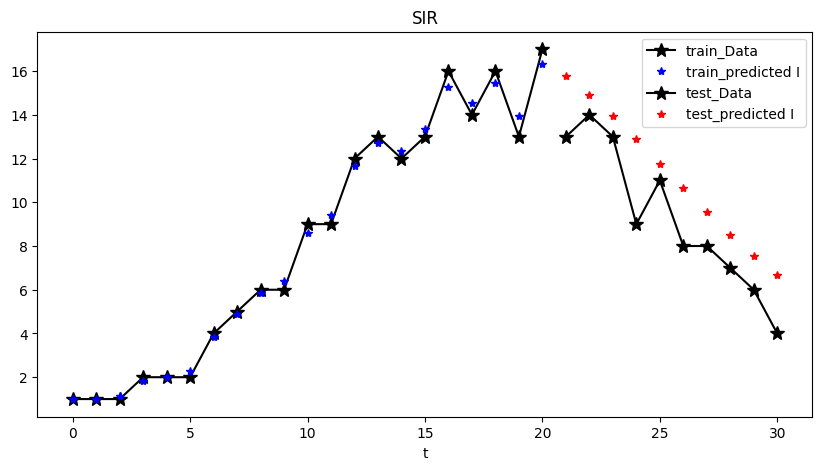

In [ ]:
U_pred = model_P.forward(x_test)
with torch.no_grad():
    plt.figure(figsize=(10,5))
    plt.title("SIR")
    plt.plot(x_train.cpu(),y_train.cpu(),'-*k', markersize=10, label='train_Data')
    plt.plot(x_train.cpu(),Data_I.cpu(),'*b', lw=2, label='train_predicted I')
    plt.plot(x_test.cpu(),y_test.cpu(),'-*k', markersize=10, label='test_Data')
    plt.plot(x_test.cpu(),U_pred.cpu()[:,1:2],'*r', lw=2, label='test_predicted I')
    plt.legend()
    plt.xlabel('t')
    plt.show()

In [ ]:
def deriv(u, N, beta, gamma):
    S,I,R= u
    dS = -beta*S*I/N
    dI = beta*S*I/N - gamma*I
    dR = gamma*I
    return np.array([dS, dI, dR])

In [ ]:
def rk4(deriv, u0, t, N, beta, gamma):
    x = np.array((len(t))*[u0]) #array of the state of the sytem for each x
    h = t[1] - t[0] #stepsize
    for i in range(len(t)-1):       #Fourth Order Runge Kutta Method
        k1 = deriv(x[i], N, beta, gamma)
        k2 = deriv(x[i] + 0.5 * k1 * h, N, beta, gamma)
        k3 = deriv(x[i] + 0.5 * k2 * h, N, beta, gamma)
        k4 = deriv(x[i] + k3 * h, N, beta, gamma)
        x[i+1] = x[i] + h * (k1 + 2*(k2 + k3) + k4) / 6.
    return x

In [ ]:
n=750
t = np.linspace(tl, tr, n+1)
u0 = S0, I0, R0
u = rk4(deriv, u0, t, N, beta, gamma)

In [ ]:
# Make test tensors
all_time_x_test = torch.Tensor(t).view(-1,1).to(device)
all_time_U_test = torch.Tensor(u).to(device)

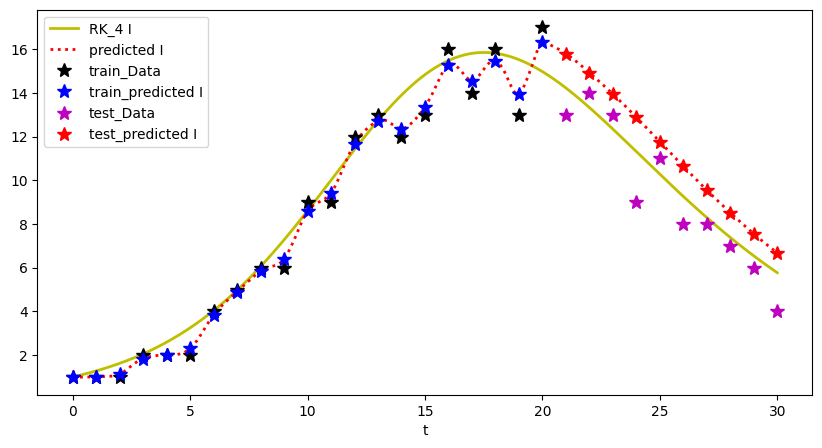

In [ ]:
all_time_U_pred = model_P.forward(all_time_x_test)
with torch.no_grad():
    plt.figure(figsize=(10,5))
    plt.plot(all_time_x_test.cpu(),all_time_U_test.cpu()[:,1:2],'y', lw=2, label='RK_4 I')
    plt.plot(all_time_x_test.cpu(),all_time_U_pred.cpu()[:,1:2],'r:', lw=2, label='predicted I')

    plt.plot(x_train.cpu(),y_train.cpu(),'*k', markersize=10, label='train_Data')
    plt.plot(x_train.cpu(),Data_I.cpu(),'*b', markersize=10, label='train_predicted I')
    plt.plot(x_test.cpu(),y_test.cpu(),'*m', markersize=10, label='test_Data')
    plt.plot(x_test.cpu(),U_pred.cpu()[:,1:2],'*r', markersize=10, label='test_predicted I')
    plt.legend()
    plt.xlabel('t')
    plt.show()

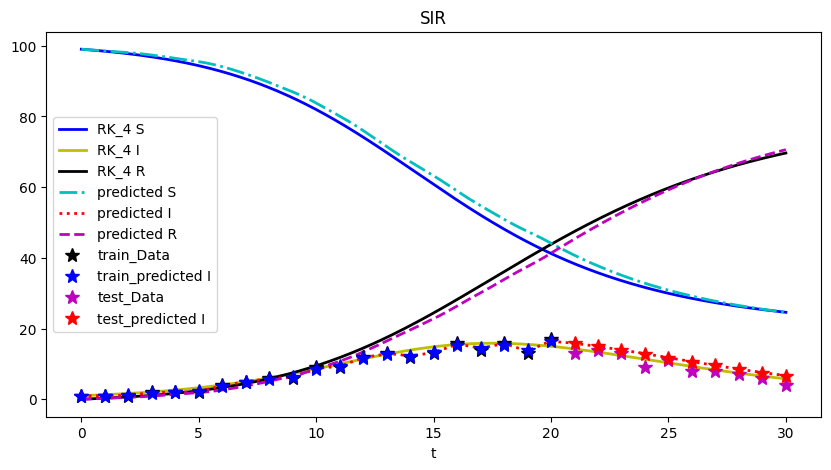

In [ ]:
all_time_U_pred = model_P.forward(all_time_x_test)
with torch.no_grad():
    plt.figure(figsize=(10,5))
    plt.title("SIR")
    plt.plot(all_time_x_test.cpu(),all_time_U_test.cpu()[:,0:1],'b', lw=2, label='RK_4 S')
    plt.plot(all_time_x_test.cpu(),all_time_U_test.cpu()[:,1:2],'y', lw=2, label='RK_4 I')
    plt.plot(all_time_x_test.cpu(),all_time_U_test.cpu()[:,2:3],'k', lw=2, label='RK_4 R')
    plt.plot(all_time_x_test.cpu(),all_time_U_pred.cpu()[:,0:1],'c-.', lw=2, label='predicted S')
    plt.plot(all_time_x_test.cpu(),all_time_U_pred.cpu()[:,1:2],'r:', lw=2, label='predicted I')
    plt.plot(all_time_x_test.cpu(),all_time_U_pred.cpu()[:,2:3],'m--', lw=2, label='predicted R')

    plt.plot(x_train.cpu(),y_train.cpu(),'*k', markersize=10, label='train_Data')
    plt.plot(x_train.cpu(),Data_I.cpu(),'*b', markersize=10, label='train_predicted I')
    plt.plot(x_test.cpu(),y_test.cpu(),'*m', markersize=10, label='test_Data')
    plt.plot(x_test.cpu(),U_pred.cpu()[:,1:2],'*r', markersize=10, label='test_predicted I')
    plt.legend()
    plt.xlabel('t')
    plt.show()